In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_absolute_percentage_error

In [88]:
dataset_train=pd.read_csv("/kaggle/input/housing/train.csv")
dataset_test=pd.read_csv("/kaggle/input/housing/test.csv")

print(dataset_train.head())
print(dataset_train.info())

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

In [89]:
missing_values=dataset_train.isnull().sum().sort_values()
print(missing_values[missing_values>0])

Electrical         1
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
BsmtFinType2      38
BsmtExposure      38
GarageQual        81
GarageFinish      81
GarageYrBlt       81
GarageType        81
GarageCond        81
LotFrontage      259
FireplaceQu      690
MasVnrType       872
Fence           1179
Alley           1369
MiscFeature     1406
PoolQC          1453
dtype: int64


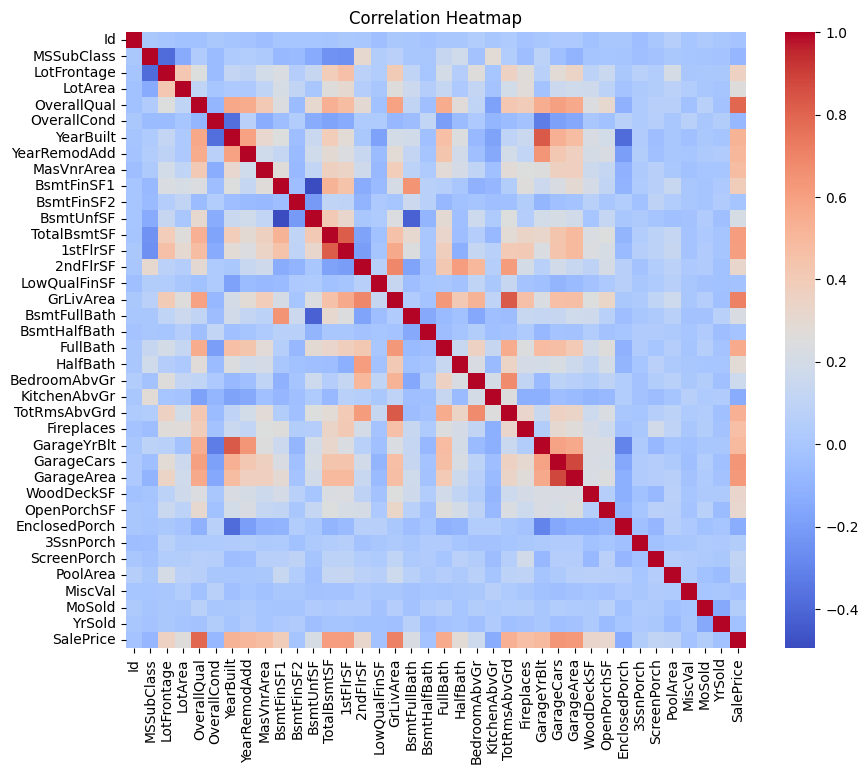

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


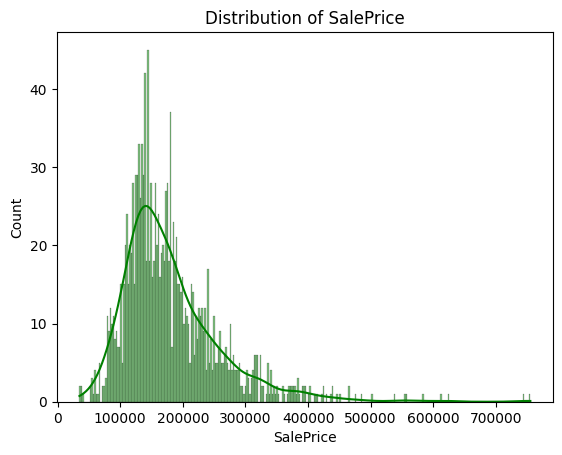

In [90]:
# Visualize correlations
numerical = dataset_train.select_dtypes(include=['number'])
corr = numerical.corr() #this is my correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.show()

# Distribution of the target variable
sns.histplot(dataset_train['SalePrice'], kde=True,bins= 300,color= "green")
plt.title("Distribution of SalePrice")
plt.show()

In [91]:
# Get the top features most correlated with SalePrice
top_features = corr['SalePrice'].sort_values(ascending=False)
print(top_features)

# Selecting features with high correlation (threshold can be adjusted)
important_features = top_features[top_features > 0.3].index
print("Highly correlated features with SalePrice:")
print(important_features)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

In [92]:
# Combine train and test datasets for consistent processing
data = pd.concat([dataset_train, dataset_test], sort=False)

# Fill missing numeric values with the median
imputer = SimpleImputer(strategy="median")
num_data = data.select_dtypes(include=["int64", "float64"])
num_data_imputed = pd.DataFrame(imputer.fit_transform(num_data), columns=num_data.columns)

# Fill missing categorical values with the most frequent
cat_data = data.select_dtypes(include=["object"])
cat_data_imputed = cat_data.fillna(cat_data.mode().iloc[0])

# Encode categorical variables
encoder = LabelEncoder()
for col in cat_data_imputed.columns:
    cat_data_imputed[col] = encoder.fit_transform(cat_data_imputed[col])

#merge
num_data_imputed = num_data_imputed.reset_index(drop=True)
cat_data_imputed = cat_data_imputed.reset_index(drop=True)

data_preprocessed = pd.concat([num_data_imputed, cat_data_imputed], axis=1)

print(data_preprocessed)

          Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  \
0        1.0        60.0         65.0   8450.0          7.0          5.0   
1        2.0        20.0         80.0   9600.0          6.0          8.0   
2        3.0        60.0         68.0  11250.0          7.0          5.0   
3        4.0        70.0         60.0   9550.0          7.0          5.0   
4        5.0        60.0         84.0  14260.0          8.0          5.0   
...      ...         ...          ...      ...          ...          ...   
2914  2915.0       160.0         21.0   1936.0          4.0          7.0   
2915  2916.0       160.0         21.0   1894.0          4.0          5.0   
2916  2917.0        20.0        160.0  20000.0          5.0          7.0   
2917  2918.0        85.0         62.0  10441.0          5.0          5.0   
2918  2919.0        60.0         74.0   9627.0          7.0          5.0   

      YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  GarageType  \
0        2003

In [93]:
# Separate the preprocessed data into train and test subsets
X = data_preprocessed[:len(dataset_train)]  # Training rows
X_test = data_preprocessed[len(dataset_train):]  # Testing rows

X = X[important_features].drop('SalePrice', axis=1)  # Exclude the target
X_test = X_test[important_features].drop('SalePrice', axis=1, errors='ignore')  # Test data doesn't have 'SalePrice'
y = dataset_train["SalePrice"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [94]:
# Train Random Forest Regressor
model = RandomForestRegressor(
    n_estimators=100,
    min_samples_split=2,
    min_samples_leaf=2,
    max_depth=7,
    random_state=42
)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
# Evaluate performance
train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
val_mape = mean_absolute_percentage_error(y_val, y_val_pred)
val_mse = mean_squared_error(y_val, y_val_pred)

# Print results
print(f"Training MAPE: {train_mape:.2%}, Training MSE: {train_mse:.2f}")
print(f"Validation MAPE: {val_mape:.2%}, Validation MSE: {val_mse:.2f}")


Training MAPE: 7.99%, Training MSE: 347555816.30
Validation MAPE: 12.14%, Validation MSE: 950867809.65


In [95]:
scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
rmse_scores = np.sqrt(-scores)
print(f"Cross-validation RMSE: {rmse_scores.mean():.2f}")

Cross-validation RMSE: 139.14


In [96]:
# Make predictions
predictions = model.predict(X_test)

# Save submission file
submission = pd.DataFrame({
    "Id": dataset_test["Id"],
    "SalePrice": predictions
})
submission.to_csv("submission.csv", index=False)


In [97]:
# Predict on the validation set
y_val_pred = model.predict(X_val)

# Calculate MAPE
mape = np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100
accuracy = 100 - mape

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Prediction Accuracy: {accuracy:.2f}%")

Mean Absolute Percentage Error (MAPE): 12.14%
Prediction Accuracy: 87.86%
